In [1]:
import os
from typing import Dict, List, Optional, Any, Literal

# Tavily API
from tavily import TavilyClient

# Langchain
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_classic.vectorstores import Chroma
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# LangChain Anthropic
from langchain_anthropic import ChatAnthropic

# Langgraph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.state import CompiledStateGraph

# Evaluation 
import mlflow
from ragas import Dataset
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics.collections import Faithfulness, FactualCorrectness, ToolCallAccuracy, AgentGoalAccuracyWithReference
from ragas import messages as ragas_messages
from ragas.integrations.langgraph import convert_to_ragas_messages
from ragas.dataset_schema import MultiTurnSample

# Anthropic
from anthropic import Anthropic

# Environment Variables
from dotenv import load_dotenv
from IPython.display import Image, display

#local Imports
#import healthbot_state
#import functions

/Users/rmiles/Desktop/local_projects/Projects/Healthbot/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv("config.env")

True

In [3]:
base_llm = ChatOpenAI(
    model="gpt-5.1",
    temperature=0.0,
    verbosity="low",
    reasoning_effort="medium",
)

In [4]:
small_llm = ChatOpenAI(
    model = "gpt-5-nano",
    temperature = 0.3,
    verbosity="low",
    reasoning_effort="medium",
)

In [5]:
quiz_grader = ChatAnthropic(
    model_name="claude-haiku-3.5",
    temperature=0.1,
    )

## Create our tool node and LLM with Tools

In [6]:
tavily_client = TavilyClient()

In [7]:
@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query.
    """
    response = tavily_client.search(question)
    print("Im conducting a very important search currently...")
    return response

In [8]:
tools = [web_search]

In [9]:
llm_with_tools = base_llm.bind_tools(tools)

## Create our State Schema

In [10]:
class State(MessagesState):
    topic: Optional[str]
    summary: Optional[str]
    quiz_question: Optional[str]
    patient_answer: Optional[str]
    evaluation: Optional[Dict[str, Any]]
    phase: Optional[
        Literal[
            "ask_topic",
            "searching",
            "show_summary",
            "waiting_ready",
            "quiz_generated",
            "waiting_answer",
            "evaluated",
            "waiting_restart"
        ]
    ]
    repeat_mode: bool

## Create an entrypoint node. 

This node should also be the introduction of the system to the user. 

This node will have an interrupt after to collect the topic the user wants to learn about. 

In [ ]:
def entrypoint(state: State)->State:
    print("Hi Im the Healthbot Assistant, here to help you understand your medical conditions, treatment\n" \
          "options, and your post-treatment care instructions. I can answer any health related questions\n" \
          "you have, and I will ensure I to aid you in understanding your post-treatment process..\n")
    sys_message = SystemMessage(
        content=(
            "You are the Healthbot Assistant, here to help patients understand their diagnoses, conditions," \
            "treatment options, and provide them post-treatment care instructions. You only answer health related " \
            "questions from the patient." \
            "Never share with the user information that is not helpful. Helpful responses are only responses that assist users" \
            "in understanding their diagnoses and the post treatment care they need to follow to have the best recover conditions."
        )
    )
    ai_message = AIMessage(
        content=(
            "What health topic or medical condition do you want to learn about?"
        )
    )
    #print("\nTell me what topic you would like to learn about: ")
    messages = [sys_message, ai_message]
   
    return {"messages": messages}

## Create our Agent nodes

 - info_agent: uses a higher tier model to gather relevant data into a larger report based on the patients interest
 - summary_agent: uses a smaller model with a subset of the state["messages"] list to process less tokens and only summarize the report generated by the large model. this should somewhat limit token usage and since summarization is a simpler task, we do not need to pass the same large report through a model that costs more during inference.
 - quiz_agent: uses the same smaller model to generate our quiz, again this is a simpler task where we can save on cost.
 - 

In [12]:
def info_agent(state: State):
    messages = state["messages"]
    topic = state["topic"]
    print("\nProcessing if we need search capability.")
    messages = messages + [topic]
    ai_message = llm_with_tools.invoke(messages)

    return {"messages": messages + [ai_message], "phase": "searching",}

In [13]:
# Create our summarizer. This node is just a base llm
def summary_agent(state: State):
    #adding check
    print("\n--- Sumarizing... ---")
    messages = state["messages"]
    last_message = state["messages"][-1]
    sys_message = SystemMessage(
            content = (
                "Please summarize this into about 3-4 paragraphs. Be concise and provide the most important information to the patient." \
                "Do not exceed 200 words. Please make each paragraph a compact block of text with about 20 words per line and a \n\n in between each paragraph."
            )
        )
    quick_message = [sys_message, last_message]
    summary = small_llm.invoke(quick_message)
    state["summary"] = summary
    #for chunk in small_llm.stream("Why do parrots have colorful feathers?"):
    #print(chunk.text, end="|", flush=True)
    messages = messages + [summary] 

    return{"messages": messages + [summary], "summary": summary.content, "repeat_mode": False, "phase": "show_summary"}
    

In [14]:
##################################################################################################################################################
# Going to need a router to our tool node or next node
##################################################################################################################################################
# CHANGE: router will route to entrypoint if theres no tool call
##################################################################################################################################################

def router_1(state: State):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [15]:
def quiz_agent(state: State):
# Is this the only node for my quiz and does the quiz need a pydantic input to be able to make sure the user answers the quiz?
    if not state["repeat_mode"]:
        summary = state["summary"]
        messages = state["messages"]

        quiz_sys_message = SystemMessage(
            content=("Analyze the following summary:"
            f"\nHere is the summary:\n>> {summary}"
            "Generate an open-ended quiz for a patient. The quiz should only be one question."
            "\nMake this quiz question about level 3 difficulty on a scale of 0 to 5. 0 being kindergaten level difficulty and 5 being highschool level deiffuculty," \
            "\nThis quiz question should be straightforward to answer as it is based only on the summary provided." \
            "\nThis quiz question will be given to a patient. Its your job to ensure the patient understands their post treatment care instructions that are present in the summary." \
            "\nOnly generate the described one quiz question, nothing else." ))
    
        print("\n---Generating the quiz to reinforce the patients understanding.---")
        
        quiz_question = small_llm.invoke([quiz_sys_message]) 
        
        print(f"Lets test your knowledge and understanding around your post-treatment care. Please answer the following:/n/n{quiz_question.content}")


        return {"messages": messages + [quiz_sys_message, quiz_question], "quiz_question": quiz_question.content, "phase": "waiting_answer"}
    else:
        return {"messages": messages + [quiz_sys_message, quiz_question], "quiz_question": quiz_question.content, "phase": "waiting_answer"}
    

# Human in the loop after the quiz is presented to collect the patients answer to the quiz question

In [16]:
# Human in the loop above here to accept the quiz answer from the patient
# Once the patient provides an answer, that answer should be updated in the state as the patients answer 
# the patients answer needs to be evaluated against the quiz summary for relevant citations(faithfulness and groundedness)

def quiz_grader_agent(state: State):
    # Pull the necessary information that will need to be processed in this node
    messages = state["messages"]
    topic = state["topic"]
    summary = state["summary"]
    patient_answer = state["patient_answer"] # This needs to be collected from the HITL

    ragas_trace = convert_to_ragas_messages(messages)


    sample = MultiTurnSample(
        user_input=ragas_trace,
        reference=summary,
        reference_topics=topic
    )

    scorer = AgentGoalAccuracyWithReference()
    scorer.llm = LangchainLLMWrapper(small_llm)
    score = scorer.multi_turn_ascore(sample)
    #curr_dataset = Dataset.from_dict(
       ## {
           # "question":[topic],
           # "answer":[patient_answer],
          #  "ground_truth":[summary],
       # }
   # )
    print(score)

    if score >= 0.7:
        print("you understand")
    else:
        print('you need more work')


    
    return {"evaluation": score, "phase": "evaluated"}

In [ ]:
#Open question quiz agent
def quiz_agent(state: State):
# Is this the only node for my quiz and does the quiz need a pydantic input to be able to make sure the user answers the quiz?
    if not state["repeat_mode"]:
        summary = state["summary"]
        messages = state["messages"]

        quiz_sys_message = SystemMessage(
            content=("Generate an open answer quiz from the summary provided below. For the patient to answer in a response" \
            "\nThis quiz will be given to a patient where its your job to make sure the patient understands that they are aware of the instructions" \
            "\nin the summary. Make the quiz question medium defficulty. Only generate the quiz question and multiple choice options. Nothing else." \
            f"\nHere is the summary:\n\n {summary}"))
    
        print("\n---Generating the quiz to reinforce the patients understanding.---")
        quiz_question = small_llm.invoke([quiz_sys_message]) 
        state["quiz_question"] = quiz_question
        quiz = state["quiz_question"]

        sys_answer_message = SystemMessage(
            content=("I need to save the correct answer to the quiz that i am testing the patient with. What is the correct answer?" \
            "Only give me the letter 'A', 'B', 'C', or 'D' for the correct answer response." \
            f"The quiz is:\n\n {quiz}"))

        quiz_correct_option = small_llm.invoke([sys_answer_message])
        return {"messages": messages + [quiz_sys_message, quiz_question], "quiz_question": quiz_question.content, "quiz_correct_option": quiz_correct_option.content, "phase": "waiting_answer"}
    else:
        return {"messages": messages + [quiz_sys_message, quiz_question], "quiz_question": quiz_question.content, "quiz_correct_option": quiz_correct_option.content, "phase": "waiting_answer"}

In [17]:
def router_2(state: State):
    repeat_mode = state["repeat_mode"]
    if repeat_mode:
        return "quiz_agent"
    return END

In [ ]:
#def new_subject(state: State)

In [18]:
#Testing the quiz_agent, summary agent, info_gather_agent with tool calling workflow.

workflow = StateGraph(State)

workflow.add_node("entrypoint", entrypoint)
workflow.add_node("info_agent", info_agent)
workflow.add_node("tools", ToolNode([web_search]))
workflow.add_node("summary_agent", summary_agent)
workflow.add_node("quiz_agent", quiz_agent)
workflow.add_node("quiz_grader_agent", quiz_grader_agent)

workflow.add_edge(START, "entrypoint")
workflow.add_edge("entrypoint", "info_agent")

workflow.add_conditional_edges(
    source = "info_agent",
    path = router_1,
    path_map = ["tools", END]
)

workflow.add_edge("tools", "info_agent")
workflow.add_edge("info_agent", "summary_agent")
workflow.add_edge("summary_agent", "quiz_agent")
workflow.add_edge("quiz_agent", "quiz_grader_agent")

workflow.add_conditional_edges(
    source="quiz_grader_agent",
    path=router_2,
    path_map=["quiz_agent", END]
)

workflow.add_edge("quiz_grader_agent", END)


In [20]:
memory = MemorySaver()
graph = workflow.compile(
    interrupt_before=["info_agent"],
    interrupt_after=["quiz_agent"],
    checkpointer = memory
)

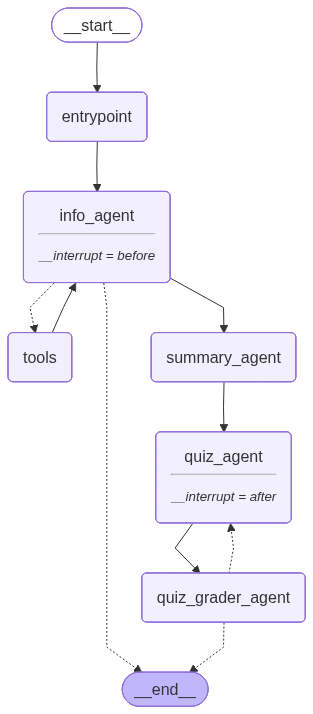

In [21]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [ ]:
topic_question = {"topic": "I want to learn about the post treatment care for an ear infection."}
config = {"configurable": {"thread_id": 1}}

### Human in the loop

Putting it all together

In [22]:
def hitl_interaction_flow(graph: CompiledStateGraph, thread_id: int):
        
    #Interrupt after the entrypoint node
    human_input_topic = input("Please input what post treatment topic you'd like to learn about:")
    human_message = HumanMessage(content=human_input_topic)
    topic = {"topic": human_input_topic}
    config = {"configurable": {"thread_id": thread_id}}
    graph.update_state(
        config = config,
        values={
            "messages":[human_message],
            "topic": human_input_topic,
        },
    )
    print("User topic entry processing...")

    for event in graph.stream(input=topic, config=config, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()

    #interrupt after quiz is presented:
    quiz_answer_input = input("Please provide an answer to the quiz below:\n>>")
    human_quiz_message = HumanMessage(content=quiz_answer_input)
    patient_answer = {"patient_answer": quiz_answer_input}
    config = {"configurable": {"thread_id": thread_id}}
    graph.update_state(
        config = config,
        values={
            "messages":[human_quiz_message],
            "patient_answer": quiz_answer_input
        },
    )
    print("Grading patient quiz...")
    for event in graph.stream(input=patient_answer, config=config, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()




In [23]:
hitl_interaction_flow(
    graph=graph,
    thread_id=1
)

User topic entry processing...
================================ Human Message =================================

high blood pressure
Hi Im the Healthbot Assistant, here to help you understand your medical conditions, treatment
options, and your post-treatment care instructions. I can answer any health related questions
you have, and I will ensure I to aid you in understanding your post-treatment process..


Tell me what topic you would like to learn about: 
================================== Ai Message ==================================

What health topic or medical condition do you want to learn about?
Grading patient quiz...
================================ Human Message =================================


Hi Im the Healthbot Assistant, here to help you understand your medical conditions, treatment
options, and your post-treatment care instructions. I can answer any health related questions
you have, and I will ensure I to aid you in understanding your post-treatment process..


Tell

In [ ]:

state

In [ ]:
for event in graph.stream(input = topic_question, config = config, stream_mode = "values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

In [ ]:
state = graph.get_state(config=config)
state

In [ ]:
state.next

In [ ]:
for event in graph.stream(input=None, config = config, stream_mode = "values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

In [ ]:
state = graph.get_state(config=config)
state

In [ ]:
state.next

In [ ]:
patient_answer = {"patient_answer": "b"}
config = {"configurable": {"thread_id": 1}}

In [ ]:
for event in graph.stream(input=patient_answer, config = config, stream_mode = "values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

In [ ]:
state = graph.get_state(config=config)

In [ ]:
state.next

In [ ]:
for event in graph.stream(input=None, config=config, stream_mode="values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

In [ ]:
state = graph.get_state(config=config)

In [ ]:
state.next

In [ ]:
state

In [ ]:
def hitl_editing_state(graph: CompiledStateGraph, topic:str, patient_answer:str, thread_id:int):
    topic = {"topic": topic}
    #config = {"configurable": {"thread_id": thread_id}}
    for event in graph.stream(input=topic, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()

    human_input = input("Do you approve the tool calling(Y or N)?: ")
        
    if human_input.lower() == "yes":
        for event in graph.stream(input=None, stream_mode="values"):
            if not event['messages']:
                continue
            event['messages'][-1].pretty_print()
    else:
        AIMessage("Please provide a topic that you want to learn about.").pretty_print()


In [ ]:
def human_in_the_loop_revision(graph: CompiledStateGraph, topic: str, thread_id: int):
    topic = {"topic": topic}
    config = {"configurable": {"thread_id": thread_id}}
    for event in graph.stream(input=None, config=config, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()
    
    topic = input(state["messages"][-1] + ":")

    if human_input.lower() == "no":
        human_input = input("So what question would you like to ask instead?: ")
        human_message = HumanMessage(content=human_input)
        system_message = SystemMessage("workflow edited by human")
        system_message.pretty_print()
        graph.update_state(
            config=config,
            values={
                "messages":[
                    system_message,
                    human_message,
                ]
            },
        )
        print("updated state, about to print the events in this graph.")
        for event in graph.stream(input=None, config=config, stream_mode="values"):
            if not event['messages']:
                continue
            event['messages'][-1].pretty_print()
            
    else:
        for event in graph.stream(input=None, config=config, stream_mode="values"):
            if not event['messages']:
                continue
            event['messages'][-1].pretty_print()